In [1]:
import matplotlib.pyplot as plt
import missingno as msno
import nltk
import numpy as np
import pandas as pd
import re
import requests
import seaborn as sns
import shutil
import textwrap
import matplotlib
from nltk.corpus import stopwords
from pathlib import Path
from wordcloud import WordCloud
import unicodedata
from collections import Counter
from typing import Optional

In [2]:
def download_file(url:str, local_filename:Optional[str]=None):
    if local_filename is None:
      local_filename = url.split('/')[-1]
    with requests.get(url, stream=True) as r:
        with open(local_filename, 'wb') as f:
            shutil.copyfileobj(r.raw, f)
    return local_filename

def unzip_file(path_to_zip_file:str, directory_to_extract_to:str):
  shutil.unpack_archive(path_to_zip_file, directory_to_extract_to)

In [3]:
# Check if the data already exists, if not, download and unzip it
data_path = Path('data')
if not (data_path / 'laboratorios.csv').is_file() and not (data_path / 'notas.csv').is_file() and not (data_path / 'sociodemografico.csv').is_file():
  data_zip = download_file('https://www.dropbox.com/sh/xgs3kyvyn7lmr6p/AACB4eORnqsJpRsjv9-56eUHa?dl=1', 'data.zip')
  unzip_file(data_zip, data_path)
  unzip_file(data_path / 'Diana Buitrago - IQVIA_NLPmediaclNotes_DianaBuitrago.zip', data_path)

# Datasets analysis

## Sociodemografico file

In [4]:
sociodemografico = pd.read_csv(str(data_path / "sociodemografico.csv"),sep=';')
sociodemografico.head(10)

,IDRecord,Edad,Genero,GrupoEtnico,AreaResidencial,EstadoCivil,TSangre
0,5,39,Mujer,Mestizo,Zona Urbana,Separado,NaN
1,292,84,Hombre,Ninguno de los anteriores,Zona Urbana,Casado,NaN
2,300,88,Hombre,Mestizo,Zona Urbana,Soltero,O+
3,307,88,Hombre,Ninguno de los anteriores,Zona Urbana,No reportado,NaN
4,325,94,Hombre,Ninguno de los anteriores,Zona Rural,Viudo/a,NaN
5,339,88,Hombre,Ninguno de los anteriores,Zona Urbana,No reportado,NaN
6,361,96,Hombre,Ninguno de los anteriores,Zona Urbana,No reportado,NaN
7,401,86,Hombre,Ninguno de los anteriores,Zona Urbana,Casado,NaN
8,406,94,Hombre,Ninguno de los anteriores,Zona Urbana,No reportado,NaN
9,433,78,Hombre,Ninguno de los anteriores,Zona Urbana,No reportado,NaN


### Numerical Features Analysis

In [5]:
sociodemografico.describe()

,IDRecord,Edad
count,9306.000000,9306.000000
mean,86430.407264,47.509349
std,41221.689013,20.123695
min,5.000000,17.000000
25%,47726.000000,31.000000
50%,87220.000000,41.000000
75%,109563.000000,61.000000
max,206307.000000,105.000000


TODO (Marcelo Alias Steven) Talk about Age, mean, STD, Boxplot, histogram

### Null value analysis

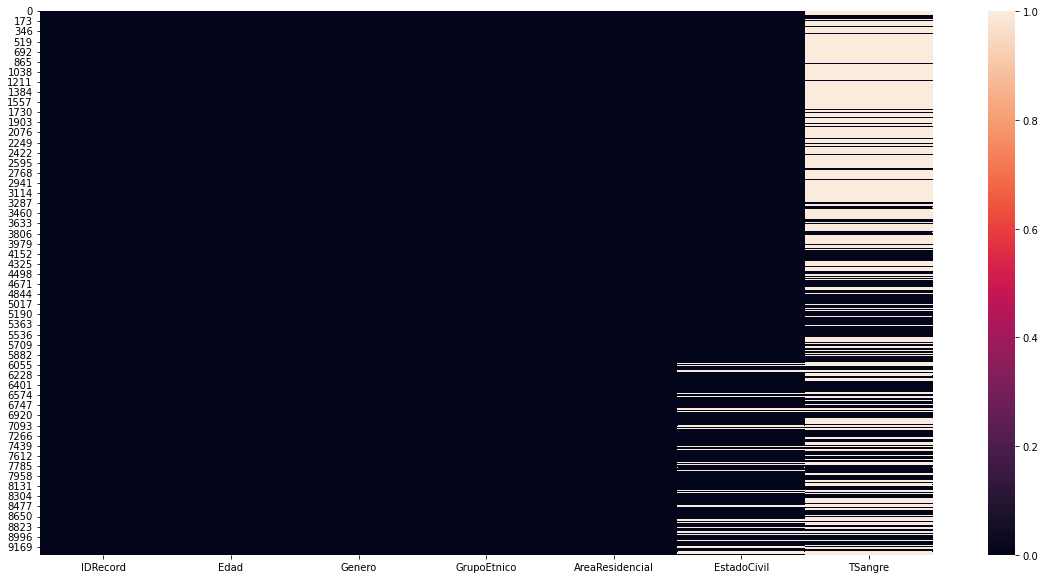

In [6]:
fig, ax = plt.subplots(figsize=(20,10))
_ = sns.heatmap(sociodemografico.isnull(), ax = ax)

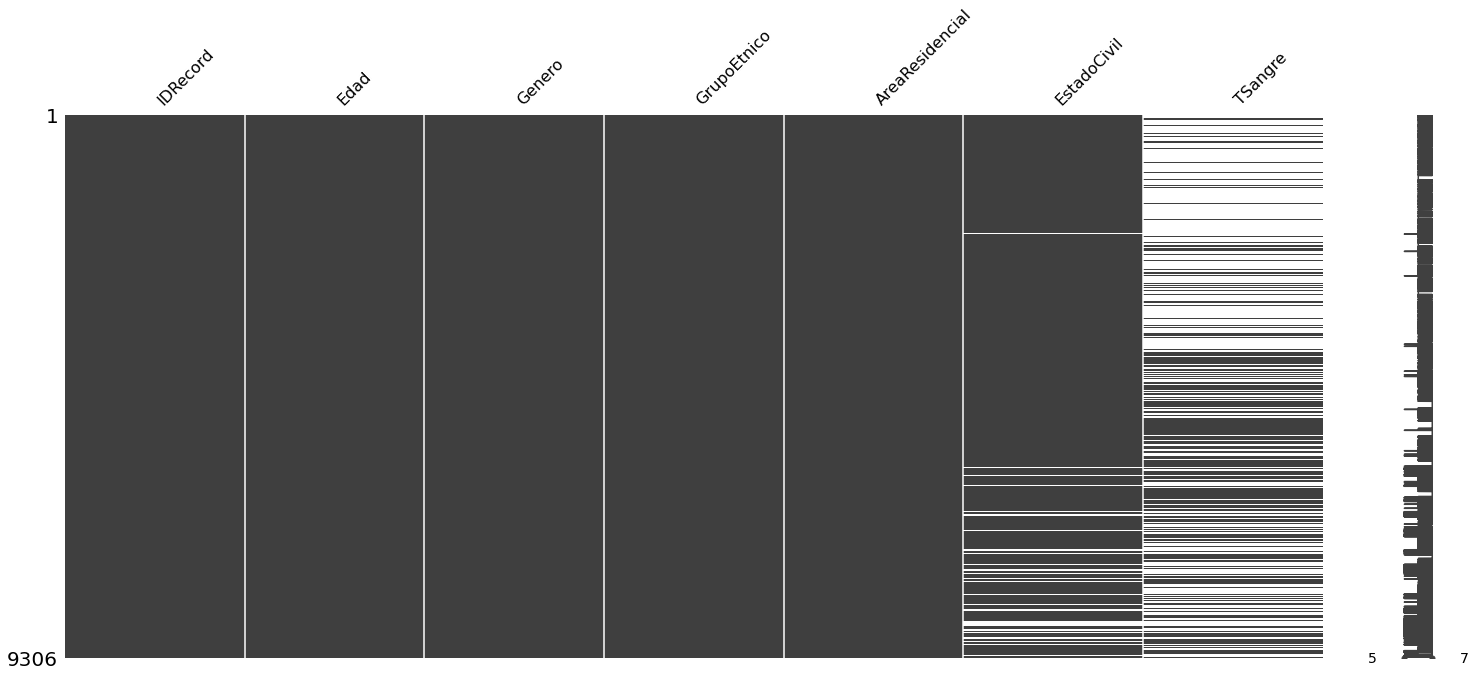

In [7]:
_ = msno.matrix(sociodemografico)

- Edad: It might give us information on to which population groups can develop one of the conditions we are trying to look for.
- Genero: It is believed that males develop diabetes easier than females, so it is possible that this feature might give us some informatio nrelated to if the patient can have a correct diagnosis.
- GrupoEtnico: It is possible that the different diets that each ethnic group has can facilitate developing diabetes, so this can be useful.
- EstadoCivil: Patients that don't have a stable relationship are exposed to higher levels of Sexually Transmitted Diseases (STDs), so this can be an indicator for Syphilis.
- TSangre: There exists a correlation between blodd type and diabetes, nonetheless we are missing many values for blood type and thus it might be difficult to use it for our analysis. 

In [8]:
# Let's drop blood type
# sociodemografico.drop(['TSangre'], axis=1, inplace=True)
# Fill missing values with 'Not available/not reported'
sociodemografico.fillna('No reportado', inplace=True)
sociodemografico.head(10)

,IDRecord,Edad,Genero,GrupoEtnico,AreaResidencial,EstadoCivil,TSangre
0,5,39,Mujer,Mestizo,Zona Urbana,Separado,No reportado
1,292,84,Hombre,Ninguno de los anteriores,Zona Urbana,Casado,No reportado
2,300,88,Hombre,Mestizo,Zona Urbana,Soltero,O+
3,307,88,Hombre,Ninguno de los anteriores,Zona Urbana,No reportado,No reportado
4,325,94,Hombre,Ninguno de los anteriores,Zona Rural,Viudo/a,No reportado
5,339,88,Hombre,Ninguno de los anteriores,Zona Urbana,No reportado,No reportado
6,361,96,Hombre,Ninguno de los anteriores,Zona Urbana,No reportado,No reportado
7,401,86,Hombre,Ninguno de los anteriores,Zona Urbana,Casado,No reportado
8,406,94,Hombre,Ninguno de los anteriores,Zona Urbana,No reportado,No reportado
9,433,78,Hombre,Ninguno de los anteriores,Zona Urbana,No reportado,No reportado


### Categorical features analysis

#### Ethnic Group (GrupoEtnico)

In [9]:
grupo_etnico = sociodemografico.GrupoEtnico.value_counts().to_frame()
grupo_etnico['percentage'] = grupo_etnico.GrupoEtnico / sum(grupo_etnico.GrupoEtnico) * 100
grupo_etnico

,GrupoEtnico,percentage
Mestizo,7157,76.907372
Ninguno de los anteriores,1270,13.647109
Blanco,529,5.684505
"Negro, Mulato, Afrocolombiano o Afro descendiente",285,3.062540
Indígena,64,0.687728
Palenquero de San Basilio,1,0.010746


We can see that we have 6 ethnic groups when counting the null value/group:
- Blanco: 529 samples
- Indigena: 64 samples
- Mestizo: 7157 samples
- Negro, Mulato, Afrocolombiano o Afro descendiente: 285
- Null: 1270 samples
- Palenquero de San Basilio: 1 sample

#### Gender (Genero)

In [10]:
gender = sociodemografico.Genero.value_counts().to_frame()
gender['percentage'] = gender.Genero / sum(gender.Genero) * 100
gender

,Genero,percentage
Hombre,7635,82.043843
Mujer,1671,17.956157


We can see that our dataset is inbalanced with respect to gender. We have only 18% of our data being of the female gender. This can affect our prediction abilities for this feature.

#### Residential Area (AreaResidencial)

In [11]:
residential_area = sociodemografico.AreaResidencial.value_counts().to_frame()
residential_area['percentage'] = residential_area.AreaResidencial / sum(residential_area.AreaResidencial) * 100
residential_area

,AreaResidencial,percentage
Zona Urbana,8931,95.970342
Zona Rural,375,4.029658


This feature is also very unbalanced, with the majority of the sample population living in urban areas.

#### Marital Status (EstadoCivil)

In [12]:
marital_status = sociodemografico.EstadoCivil.value_counts().to_frame()
marital_status['percentage'] = marital_status.EstadoCivil / sum(marital_status.EstadoCivil) * 100
marital_status

,EstadoCivil,percentage
Soltero,4268,45.862884
Desconocido,1637,17.590802
No reportado,1245,13.378466
Casado,876,9.413282
Unión libre,511,5.491081
Viudo/a,480,5.157963
Separado,256,2.750913
Divorciado,33,0.354610


Marital status also indicates that there is a large unbalance in our data, with almost half of the samples belonging to the 'Single' category.

#### Blood type (TSangre)

In [13]:
blood_type = sociodemografico.TSangre.value_counts().to_frame()
blood_type['percentage'] = blood_type.TSangre / sum(blood_type.TSangre) * 100
blood_type

,TSangre,percentage
No reportado,5505,59.155384
O+,2964,31.850419
A+,545,5.856437
B+,152,1.633355
O-,80,0.859660
AB+,25,0.268644
A-,24,0.257898
B-,9,0.096712
AB-,2,0.021492


Blood type, apart from also being heavily unbalanced, is missing inofrmation on almost 60% of the samples. It seems that it might be necessary to drop this feature from our list.

TODO (Jorge): Comparar grupo sanguineo con las otras variables de sociodemografico, buscar si hay relaciones entre datos faltantes y ej genero, area residencial, etc. Comaprar tambien grupo sanguineo no faltante con als otras variable.

## Laboratorios file

TODO (Daniel): Analisis de valores nulos y todo lo de la seccion de Laboratorios

In [14]:
laboratorios = pd.read_csv(str(data_path / "laboratorios.csv"),sep=';')

In [15]:
laboratorios.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189643 entries, 0 to 189642
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   IDRecord  189643 non-null  int64 
 1   Codigo    189643 non-null  object
 2   Nombre    189643 non-null  object
 3   Fecha     189643 non-null  object
 4   Valor     161754 non-null  object
dtypes: int64(1), object(4)
memory usage: 7.2+ MB


In a preliminary view of the data, we can see that in total we have 189.643 entries with a total of 5 columns of which one is an int number and the rest are strings.

In [16]:
laboratorios.head(20)

,IDRecord,Codigo,Nombre,Fecha,Valor
0,95627,902045,TIEMPO DE PROTROMBINA (PT),22/02/2022 18:43,NaN
1,125572,902045,TIEMPO DE PROTROMBINA (PT),17/02/2022 13:41,NaN
2,55788,902045,TIEMPO DE PROTROMBINA (PT),22/06/2021 12:50,1.05
3,113766,902045,TIEMPO DE PROTROMBINA (PT),5/08/2021 12:11,NaN
4,44596,902045,TIEMPO DE PROTROMBINA (PT),5/08/2021 13:15,NaN
5,44596,902049,TIEMPO DE TROMBOPLASTINA PARCIAL (PTT),5/08/2021 13:15,40.80
6,55788,902049,TIEMPO DE TROMBOPLASTINA PARCIAL (PTT),22/06/2021 12:50,28.00
7,95627,902049,TIEMPO DE TROMBOPLASTINA PARCIAL (PTT),22/02/2022 18:43,37.10
8,125572,902049,TIEMPO DE TROMBOPLASTINA PARCIAL (PTT),17/02/2022 13:41,38.20
9,93070,902049,TIEMPO DE TROMBOPLASTINA PARCIAL (PTT),15/01/2022 12:42,33.50


In a quick glimpse at the data itself we have int the ‘laboratorios’ dataset information about the code of the patient, the code of the laboratory test, the name of the laboratory test, the date of the test, and the value of each test taken.

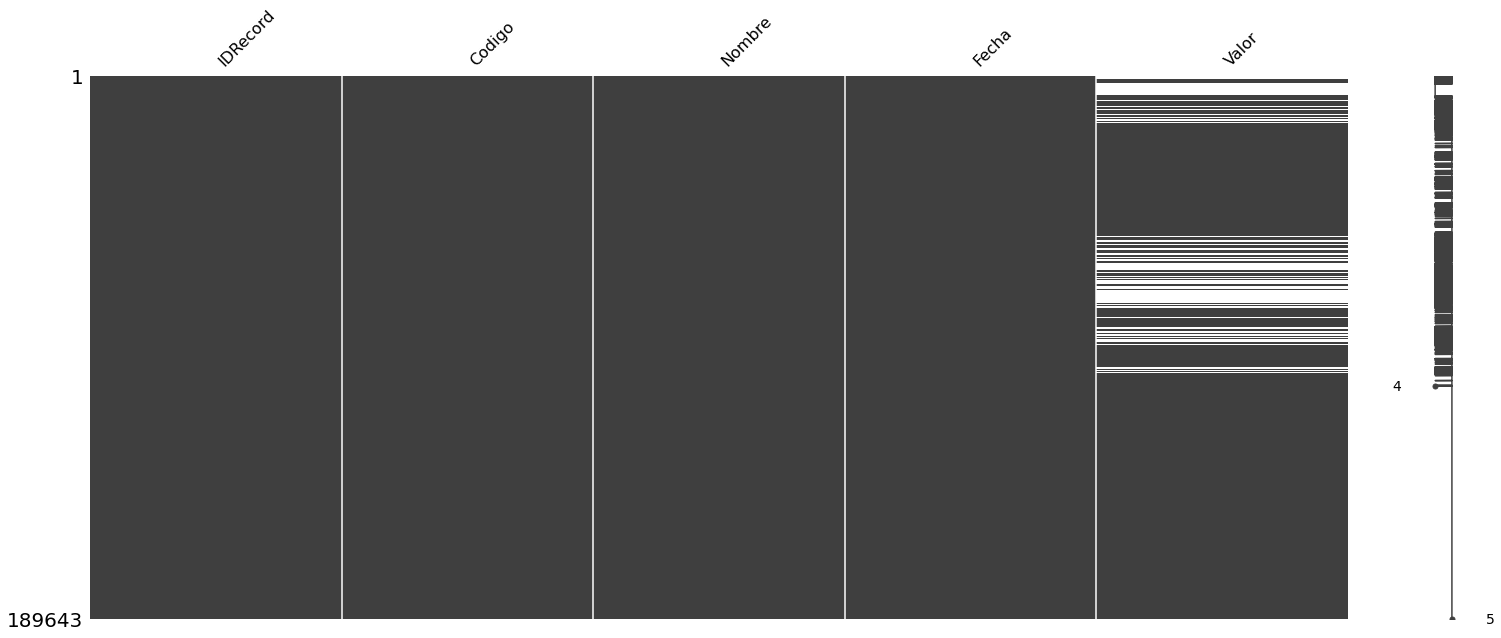

In [17]:
_ = msno.matrix(laboratorios)

As we can see the only column that has null values is the ‘Valor’ column which represents the value obtained in the test made on the patient.

In [18]:
laboratorios.Valor.isnull().sum()

27889

We have a total of 27.889 entries with 'Valor' column null. That represents the 14.07% of all the entries.

### Numerical Features Analysis

#### Date (Fecha)

In [19]:
laboratorios.Fecha = pd.to_datetime(laboratorios.Fecha)

In [20]:
laboratorios.Fecha.describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


count                  189643
unique                   8292
top       2020-10-14 00:00:00
freq                      383
first     2001-12-09 00:00:00
last      2022-12-03 14:56:00
Name: Fecha, dtype: object

After turning the ‘Fecha’ column into datetime and running the describe command we can see that we have laboratory tests from December 9, 2001 to December 3, 2022. Being the date with the most test taken October 14 2020.

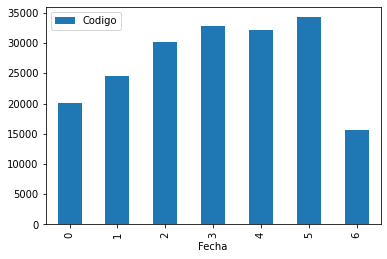

In [21]:
week_df = laboratorios.groupby(laboratorios.Fecha.dt.weekday).count()
week_df.plot(kind="bar", y="Codigo")

We can see that the take test 7 days of the week, being the day with most test saturday

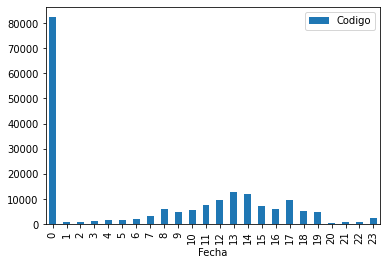

In [22]:
hour_df = laboratorios.groupby(laboratorios.Fecha.dt.hour).count()
hour_df.plot(kind="bar", y="Codigo")

Watching the hours that are in the dataset we can see that the hour with most tests taken is 0 hours, having another pick on the 13 hours

In [23]:
# TODO: between exams of patients

#### Value (Valor)

TODO: Describe average values, max, min, by test type/code. 

TODO: Analyze how is the missing data related to each patient: Are datapoints missing for a specific patient, are we only loosing e.g. one of the measurements done in a patient from 5? Etc

### Categorical Features analysis

#### Code (Codigo)

In [24]:
code = laboratorios.Codigo.value_counts().to_frame()
code['percentage'] = code.Codigo / sum(code.Codigo) * 100
code.sort_values(by="percentage", ascending=False)
code.columns = ["quantity", "percentage"]
code

,quantity,percentage
903895,11712,6.175815
903815,11492,6.059807
903818,10462,5.516681
903868,9905,5.222972
903866,9353,4.931898
...,...,...
890380,1,0.000527
90624902,1,0.000527
05894-T,1,0.000527
99350202_X,1,0.000527


The table above presents the different laboratory test codes in the dataset with the percetage of records found in it. There are 180 in total.

As we can see, the test most employeed is the one with the code 903895 with 6.17% of records found. Then, tests 903815 and 903818 with 6.05% and 5.51% respectively. On the other hand, there are test with just 1 records found in the dataset (i.g. test 906233, among others).

Adittionally, we can observe that some codes are no completly numerical. We can see codes with som characters such as "05894-T" and "99350202_X	".

In [25]:
code = code.reset_index()

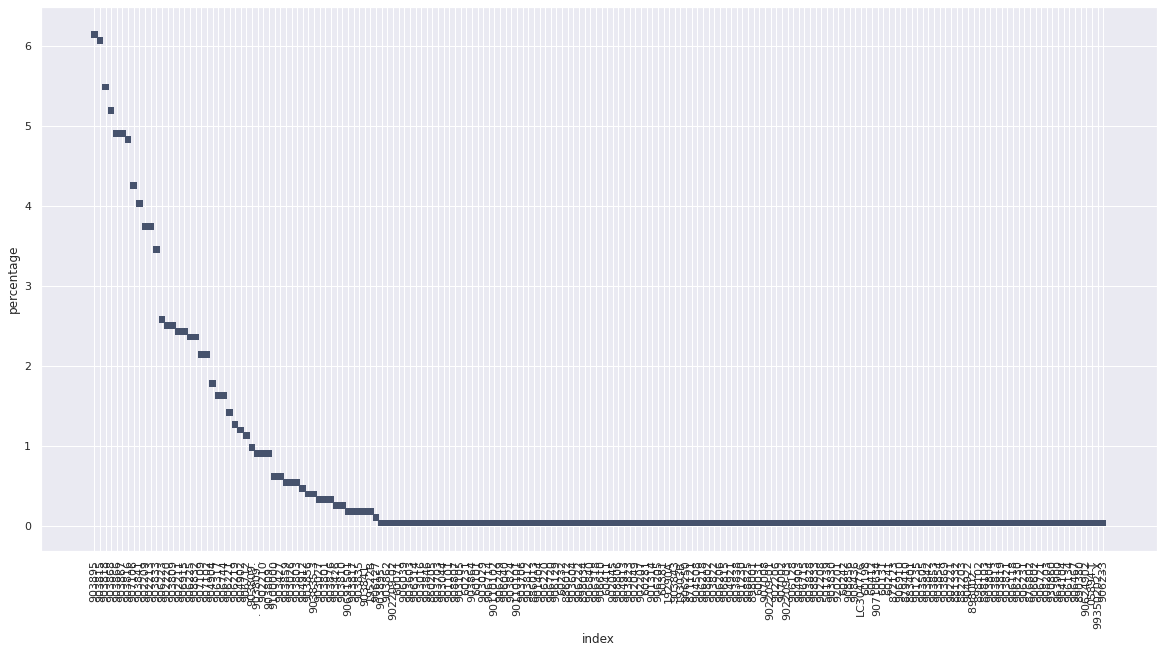

In [26]:
sns.set(rc = {'figure.figsize':(20,10)})
plt.xticks(rotation=90)
code_plot = sns.histplot(data=code, x="index", y="percentage")

If we look into the values through the plot below, we can see the following:
*   A few kind of test are between 3 and around 6%.
*   Then, other group of test range from almost 1% and less than 3%
*   The major part of the test have a percentage lower than 1%

The next plot present the ones with a percentage equal or more than 1%

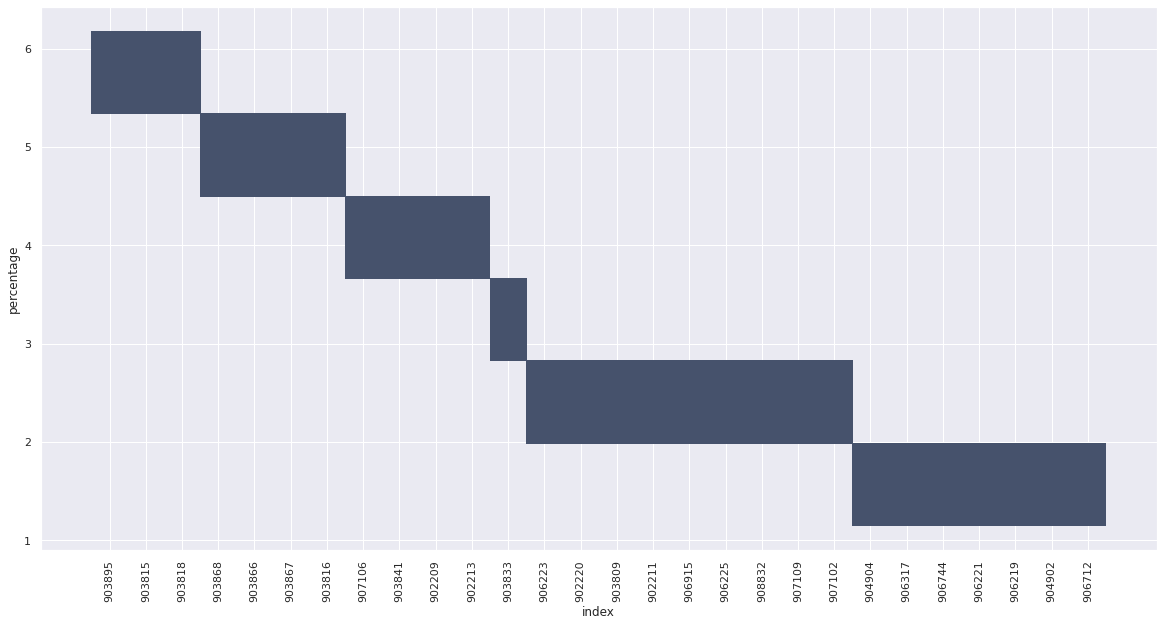

In [27]:
top_tests = code[code.percentage >= 1]
sns.set(rc = {'figure.figsize':(20,10)})
plt.xticks(rotation=90)
top_tests_plot = sns.histplot(data=top_tests, x="index", y="percentage")

#### Name (Nombre)

In [28]:
name = laboratorios.Nombre.value_counts().to_frame()
name['percentage'] = name.Nombre / sum(name.Nombre) * 100
name

,Nombre,percentage
CREATININA,11841,6.243837
COLESTEROL DE ALTA DENSIDAD (HDL),11492,6.059807
COLESTEROL TOTAL,10462,5.516681
TRIGLICÉRIDOS,9905,5.222972
TRANSAMINASA GLUTÁMICOPIRÚVICA O ALANINO AMINO TRANSFERASA (TGP-ALT),9353,4.931898
...,...,...
VIH 1 Y 2 ANTICUERPOS SEGUNDA PRUEBA,1,0.000527
prueba de Tropismo vírico,1,0.000527
"XEROMAMOGRAFIA O MAMOGRAFIA, BILATERAL",1,0.000527
HEPATITIS A MAYORES DE 19 A,1,0.000527


Now, we can see the different names for the laboratory tests. Some of them are larger than others. Besides, there are somes names registered in lower case and others with upper case. It can be standarized by transforming all names to lower case.

Here, we can notice a difference between the amount of records of this table with names and the one previously showed with codes. While in the first table are 180 records, this present 178. It can suggest there are some names duplicated. To verify this, we can explore its values as following:

In [29]:
name_code = laboratorios[['Nombre', 'Codigo']].value_counts().reset_index().rename({0:'Count'}, axis=1)
# name['percentage'] = name.Nombre / sum(name.Nombre) * 100
name_code

,Nombre,Codigo,Count
0,CREATININA,903895,11712
1,COLESTEROL DE ALTA DENSIDAD (HDL),903815,11492
2,COLESTEROL TOTAL,903818,10462
3,TRIGLICÉRIDOS,903868,9905
4,TRANSAMINASA GLUTÁMICOPIRÚVICA O ALANINO AMINO...,903866,9353
...,...,...,...
175,IRRIGACION O ENEMA TRANSANAL SOD,963900,1
176,TEST DE AVIDEZ ANTICUERPOS Ig G TOXOPLASMA SEM...,906134,1
177,ESTUDIO DE COLORACIÓN BASICA EN CITOLOGIA DE L...,898002,1
178,TIROXINA TOTAL (T4),904922,1


We create a table with both columns: Nombre and Codigo. Here, we have 180 rows in total. Now, let's find the duplicate by nombre.

In [30]:
name_code[name_code.Nombre.duplicated()]

,Nombre,Codigo,Count
51,CREATININA,903895..,129
150,TRANSAMINASA GLUTÁMICO OXALACÉTICA O ASPARTATO...,60242,1


As we can see, there are two test that are more than once in our data. No, we can find them to see in detail each of the duplicates

In [31]:
name_code[name_code.Nombre == "CREATININA"]

,Nombre,Codigo,Count
0,CREATININA,903895,11712
51,CREATININA,903895..,129


In [32]:
name_code[name_code.Codigo == "60242"].Nombre.values

array(['TRANSAMINASA GLUTÁMICO OXALACÉTICA O ASPARTATO AMINO TRANSFERASA [TGO-AST] . .'],
      dtype=object)

The code below is for extracting the full name of the second test duplicated

In [33]:
name_code[name_code.Nombre == "TRANSAMINASA GLUTÁMICO OXALACÉTICA O ASPARTATO AMINO TRANSFERASA [TGO-AST] . ."]


,Nombre,Codigo,Count
139,TRANSAMINASA GLUTÁMICO OXALACÉTICA O ASPARTATO...,60241,1
150,TRANSAMINASA GLUTÁMICO OXALACÉTICA O ASPARTATO...,60242,1


With the duplicates identified, we can proceed to unify them, particularly by the code.

## Notas file

TODO (Juan): Analisis archivo Notas

In [34]:
notas = pd.read_csv(str(data_path / "notas.csv"),sep=';')
notas.head()

,IDRecord,Código,Nombre,Tipo,Plan
0,44600,A539,"SIFILIS, NO ESPECIFICADA",Confirmado Repetido,- ORDENO TAR ABC +3TC +ATV/r - PROFILAXIS NO ...
1,45038,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,- TAF/FTC/EVG/C MIPRES POR 2 MESES 20200602158...
2,40391,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,usuaria la cual se ve pertinente seguimiento d...
3,106350,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,1. Se formula TAR (TDF/FTC+EFV) 2. S/S Paracl...
4,105840,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,EDUCACIÓN Se brinda retroalimentación con rel...


In [35]:
notas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140227 entries, 0 to 140226
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   IDRecord  140226 non-null  object
 1   Código    140179 non-null  object
 2   Nombre    140178 non-null  object
 3   Tipo      140176 non-null  object
 4   Plan      140117 non-null  object
dtypes: object(5)
memory usage: 5.3+ MB


### Null value analysis

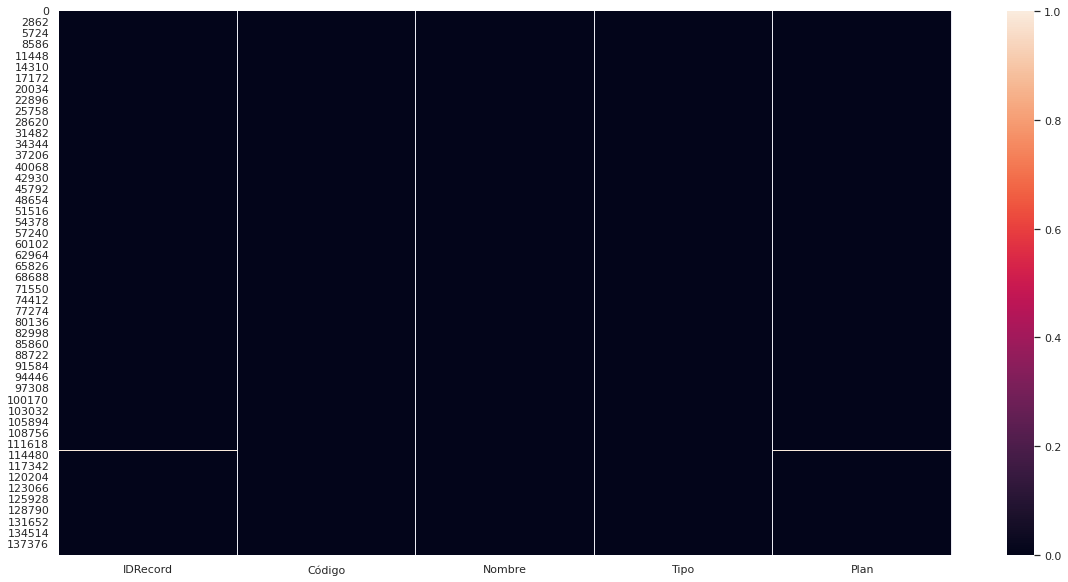

In [36]:
fig, ax = plt.subplots(figsize=(20,10))
_ = sns.heatmap(notas.isnull(), ax=ax)

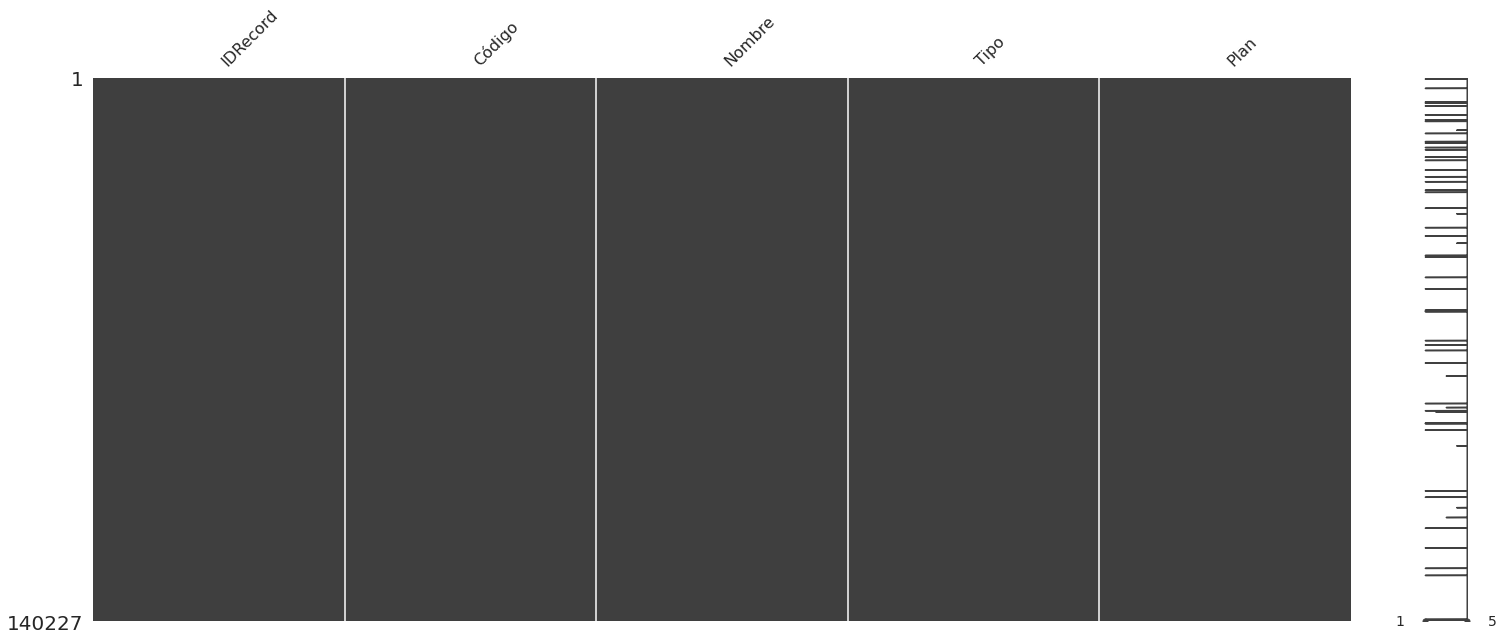

In [37]:
_ = msno.matrix(notas)

In [38]:
notas.isnull().sum()

IDRecord      1
Código       48
Nombre       49
Tipo         51
Plan        110
dtype: int64

It seems we do have some null values in the different features of our dataset. Let's see what we can do with them:
- IDRecord:
We can't replace IDRecord as that is a unique value used for joining together the information of the different datasets. 
- Code/Name:
Code/Name would be the feature we would be trying to predict on, so we can't fill those either. However, each Name uniquely correspond to each Code, so we might be able to recover some missing values with that
- Type, Plan:
We can do a simple inputting and replace the missing values from the null samples for the rest of the samples, in order to see if we can use the rest of the data found in the other datasets to predict the condition of the patient.

In [39]:
# Dropping null values from IDRecord
notas.dropna(subset=['IDRecord'], inplace=True)

In [40]:
# Checking to see what we can do with  Code and Name
notas[notas[['Código', 'Nombre']].isnull().any(axis=1)]

,IDRecord,Código,Nombre,Tipo,Plan
346,"ÍNTOMAS COMO DOLOR DE GARGANTA, DOLOR DE CABEZ...",NaN,NaN,NaN,NaN
2756,FARMACEUTICA: PENDIENTE TRABAJO SOCIAL: FEB/2...,NaN,NaN,NaN,NaN
6298,"Psicología, Nutrición, Trabajo social, Químic...",NaN,NaN,NaN,NaN
6314,"ncia, motivación para proyecto de vida, estilo...",NaN,NaN,NaN,NaN
6552,MIDA CON RESTRICCIÓN DE CARBOHIDRATOS SIMPLES ...,NaN,NaN,NaN,NaN
7285,ENA RESPUESTA AL TRATAMINTO ( RPR INICIAL EN 3...,NaN,NaN,NaN,NaN
9588,ndiente aplicar 2da dosis de vacuna contra VHB...,NaN,NaN,NaN,NaN
10890,"ROMORFONA 2.5 MG VO CADA 8 HORAS, 1 CADA 8 HOR...",NaN,NaN,NaN,NaN
11267,CIONADO PACIENTE DICE ENTENDER Y ACEPTAR. PR...,NaN,NaN,NaN,NaN
14380,adoptadas para evitar las infecciones respirat...,NaN,NaN,NaN,NaN


It seems we're missing the same data for both Name and Code features, except for one that contains the Plan for one of the samples. At the same time, we can see that the samples that have NaN for Code and/or Name also have a problem with their IDRecord, making them unusable. 

In [41]:
# Drop samples where both Code and Name are null
notas.dropna(how='all', subset=['Código', 'Nombre'], inplace = True)

In [42]:
notas.isnull().sum()

IDRecord     0
Código       0
Nombre       1
Tipo         3
Plan        61
dtype: int64

The rest of the null values will be dealt with on each of the different following subsections.

### Numerical features analysis

#### IDRecord

IDRecord should be numeric according to the dataset description provided by IQVIA, but it's showing as an object dtype, which indicates that it has non-numeric values in it. Let's try and look at what is happening

In [43]:
notas[~notas.IDRecord.str.isnumeric()]

,IDRecord,Código,Nombre,Tipo,Plan
76968,SPECIFICADA,Confirmado Repetido,A/ PACIENTE CON DX DE INFECCION POR VIH HACE C...,NaN,NaN
85091,"TE, NO ESPECIFICADA COMO PRECOZ O TARDIA",Confirmado Repetido,CONTINUA CON IGUAL MANEJO TARV. SE SOCLITA RP...,NaN,NaN
86209,ado Repetido,EMPEZÓ TAR EN DIC/15 SE REFORMULA IGUAL TAR ...,NaN,NaN,NaN


So as we saw in the null value analysis, we have some samples that instead of having their IDRecord, they have information from other features. Let's remove those as well as without IDRecord we can't relate the data to a specific patient and thus it proves non-useful for us.

In [44]:
notas['IDRecord'] = pd.to_numeric(notas['IDRecord'], errors='coerce')
notas.dropna(subset=['IDRecord'], inplace = True)
notas.head(10)

,IDRecord,Código,Nombre,Tipo,Plan
0,44600.0,A539,"SIFILIS, NO ESPECIFICADA",Confirmado Repetido,- ORDENO TAR ABC +3TC +ATV/r - PROFILAXIS NO ...
1,45038.0,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,- TAF/FTC/EVG/C MIPRES POR 2 MESES 20200602158...
2,40391.0,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,usuaria la cual se ve pertinente seguimiento d...
3,106350.0,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,1. Se formula TAR (TDF/FTC+EFV) 2. S/S Paracl...
4,105840.0,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,EDUCACIÓN Se brinda retroalimentación con rel...
5,188030.0,A539,"SIFILIS, NO ESPECIFICADA",Confirmado Repetido,1. Continuar TAR con: ABC/3TC+EFV. 2. Tomar l...
6,41590.0,A539,"SIFILIS, NO ESPECIFICADA",Confirmado Repetido,a) Se continua manejo iniciado 19/02/2020 a AB...
7,111487.0,A539,"SIFILIS, NO ESPECIFICADA",Confirmado Repetido,Control según frecuencias
8,69603.0,E119,DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...,Confirmado Repetido,Se realiza control de enfermería el 16 de OCTU...
9,69563.0,A514,OTRAS SIFILIS SECUNDARIAS,Confirmado Repetido,1. TRATAMIENTO TDF/FTC/EFV 2. PROFILAXIS:NO...


### Categorical Features Analysis

As the name suggests, the following features should be of type String

#### Code (Código)

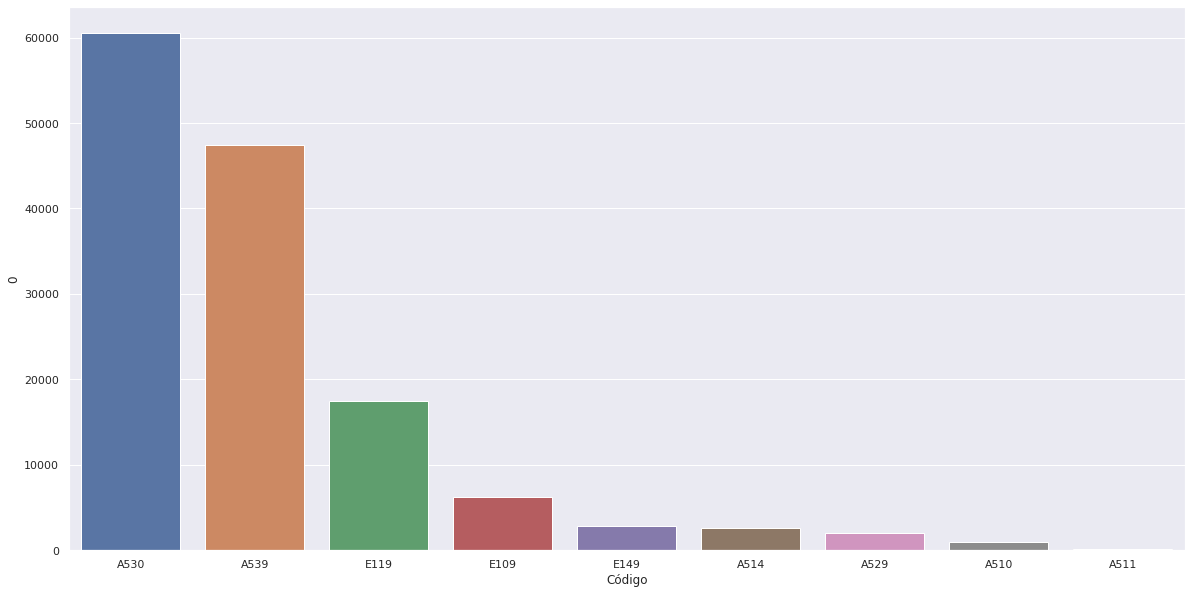

In [45]:
enfermedades = notas.groupby('Código').size()
enfermedades = enfermedades.to_frame()
enfermedades = enfermedades.reset_index()
enfermedades = enfermedades.sort_values(by=(0),ascending=False).head(9)

fig, ax = plt.subplots(figsize=(20,10))
_ = sns.barplot(x="Código", y=0, data=enfermedades, ax=ax)

We can see that we have 9 unique codes in our dataset. These codes are based on the [ICD-10](https://icd.who.int/browse10/2019) Code system, where each disease is characterized by a  unique number. In our case we have, in alphabetical order:
- [A510](https://icd.who.int/browse10/2019/en#A51.0): 
Primary genital syphilis
- [A511](https://icd.who.int/browse10/2019/en#A51.1): Primary anal syphilis
- [A514](https://icd.who.int/browse10/2019/en#A51.4): Other secondary syphilis
- [A529](https://icd.who.int/browse10/2019/en#A52.9): Late syphilis, unspecified
- [A530](https://icd.who.int/browse10/2019/en#A53.0): Latent syphilis, unspecified as early or late
- [A539](https://icd.who.int/browse10/2019/en#A53.9): Syphilis, unspecified
- [E109](https://icd.who.int/browse10/2019/en#E10.9): Type 1 diabetes mellitus
- [E119](https://icd.who.int/browse10/2019/en#E11.9): Type 2 diabetes mellitus
- [E149](https://icd.who.int/browse10/2019/en#E14.9): Unspecified diabetes mellitus


In [46]:
code = notas.Código.value_counts().to_frame()
code['percentage'] = code.Código / sum(code.Código) * 100
code

,Código,percentage
A530,60586,43.221687
A539,47408,33.820581
E119,17439,12.440877
E109,6278,4.478687
E149,2808,2.003210
A514,2614,1.864812
A529,1970,1.405386
A510,977,0.696986
A511,94,0.067059
"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O TARDIA",1,0.000713


As we can see from the barplot and the value counts, we have the different codes for the diseases plus data related to Plan, which shouldn't be here. Let's see if we can recover the Code for this sample:

In [47]:
notas[['Código','Nombre']].value_counts().reset_index().rename({0:'Frequency'}, axis=1)

,Código,Nombre,Frequency
0,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",60586
1,A539,"SIFILIS, NO ESPECIFICADA",47408
2,E119,DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...,17439
3,E109,DIABETES MELLITUSINSULINODEPENDIENTE SIN MENCI...,6278
4,E149,"DIABETES MELLITUS, NO ESPECIFICADA SIN MENCION...",2808
5,A514,OTRAS SIFILIS SECUNDARIAS,2614
6,A529,"SIFILIS TARDIA, NO ESPECIFICADA",1970
7,A510,SIFILIS GENITAL PRIMARIA,977
8,A511,SIFILIS PRIMARIA ANAL,94
9,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,1


In [48]:
notas[notas.Nombre == 'Confirmado Repetido']

,IDRecord,Código,Nombre,Tipo,Plan
42708,30.0,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,*Control por Trabajo Social según frecuencia y...,NaN


It seems that we could move all the columns to the right starting from Code. We can then take advantage of the fact that each Code follows the ICD-10 code specification, in order to fully recover the misaligned data point.



In [49]:
index = notas[notas.Nombre == 'Confirmado Repetido'].index
notas.loc[index, ['Nombre', 'Tipo', 'Plan']] = notas.loc[index, ['Código', 'Nombre', 'Tipo']].to_numpy()
notas.loc[index, 'Código'] = notas[notas['Nombre'] == notas.loc[index, 'Código'].iat[0]]['Código'].iloc[0]
notas.loc[index]

,IDRecord,Código,Nombre,Tipo,Plan
42708,30.0,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,*Control por Trabajo Social según frecuencia y...


#### Name (Nombre)

Let's take a look now at Name, which represents the condition that each patient in the dataset has.

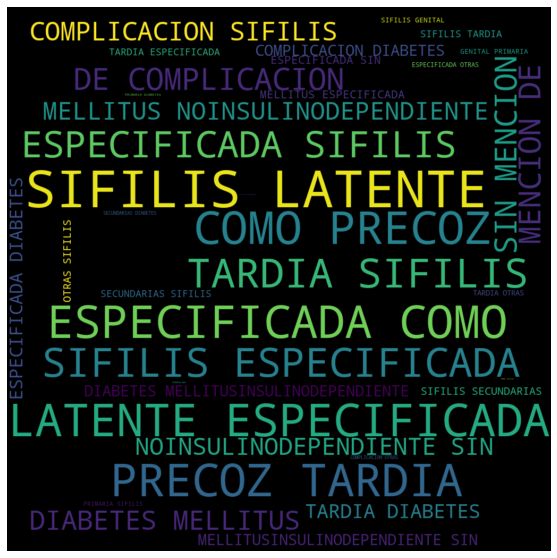

In [50]:
wordcloud = WordCloud(width=1024, height=1024).generate(notas.Nombre.str.cat(sep=' ').replace(',',''))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

In [51]:
(notas[['Código','Nombre']].value_counts(normalize=True).mul(100).round(1).astype(str) + '%').reset_index().rename({0:'Percentage'}, axis=1)

,Código,Nombre,Percentage
0,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",43.2%
1,A539,"SIFILIS, NO ESPECIFICADA",33.8%
2,E119,DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...,12.4%
3,E109,DIABETES MELLITUSINSULINODEPENDIENTE SIN MENCI...,4.5%
4,E149,"DIABETES MELLITUS, NO ESPECIFICADA SIN MENCION...",2.0%
5,A514,OTRAS SIFILIS SECUNDARIAS,1.9%
6,A529,"SIFILIS TARDIA, NO ESPECIFICADA",1.4%
7,A510,SIFILIS GENITAL PRIMARIA,0.7%
8,A511,SIFILIS PRIMARIA ANAL,0.1%


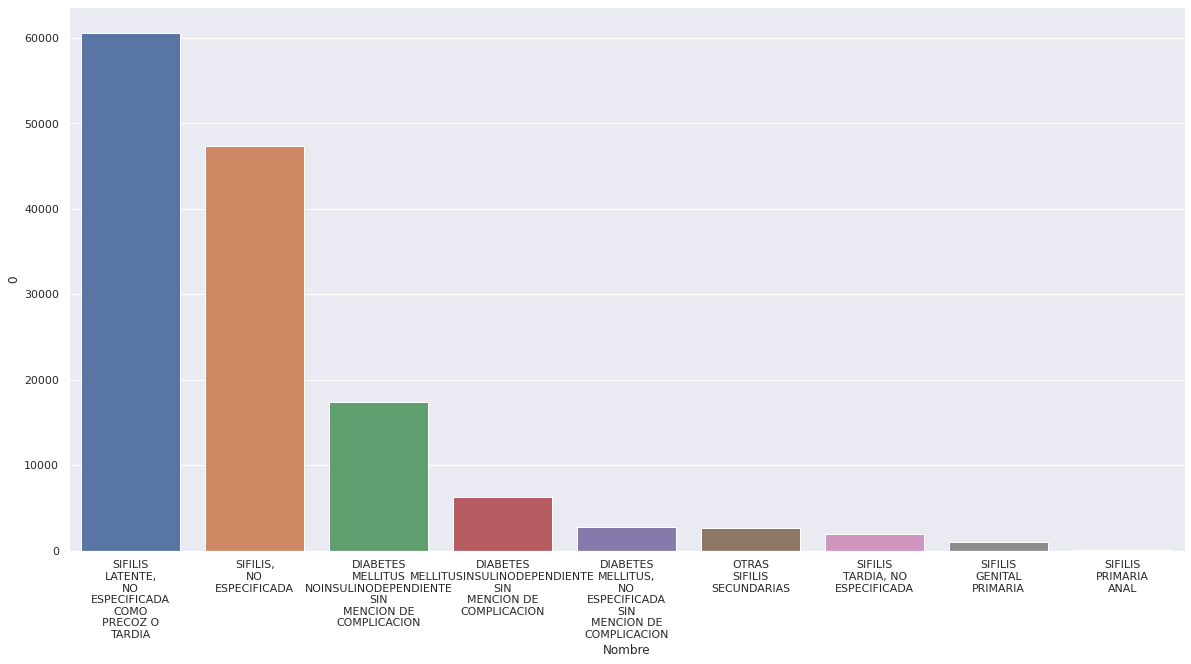

In [52]:
def wrap_labels(ax:matplotlib.axes.Axes, width:int, break_long_words:bool = False):
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=break_long_words))
    ax.set_xticklabels(labels, rotation=0)

fig, ax = plt.subplots(figsize=(20,10))
ax = sns.barplot(x="Nombre", y=0, data=notas[['Código', 'Nombre']].value_counts().to_frame().reset_index(), ax=ax)
wrap_labels(ax, 10)

In [53]:
# Separated by the main two diseases
c = notas['Código'].str.slice(stop=2).value_counts(dropna=False)
p = notas['Código'].str.slice(stop=2).value_counts(dropna=False, normalize=True).mul(100).round(1).astype(str) + '%'
pd.concat([c,p], axis=1, keys=['Count', 'Percentage'])

,Count,Percentage
A5,113650,81.1%
E1,26525,18.9%


As we can see from the dataset, around 80% of the dataset is related to Syphilis, while the remaining 20% relates to Diabetes, making the dataset very unbalanced with respect to the target variable for prediction. It is possible we will need to find a way to balance the data to be able to correctly predict between the two target classes.

We have the same information in Name as we do in Code, as it's the string representation of the ICD-10 Code

In [54]:
name = notas.Nombre.value_counts().to_frame()
name['percentage'] = name.Nombre / sum(name.Nombre) * 100
name

,Nombre,percentage
"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O TARDIA",60587,43.222401
"SIFILIS, NO ESPECIFICADA",47408,33.820581
DIABETES MELLITUS NOINSULINODEPENDIENTE SIN MENCION DE COMPLICACION,17439,12.440877
DIABETES MELLITUSINSULINODEPENDIENTE SIN MENCION DE COMPLICACION,6278,4.478687
"DIABETES MELLITUS, NO ESPECIFICADA SIN MENCION DE COMPLICACION",2808,2.003210
OTRAS SIFILIS SECUNDARIAS,2614,1.864812
"SIFILIS TARDIA, NO ESPECIFICADA",1970,1.405386
SIFILIS GENITAL PRIMARIA,977,0.696986
SIFILIS PRIMARIA ANAL,94,0.067059


#### Type (Tipo)

In [55]:
df_type = notas.Tipo.value_counts().to_frame()
df_type['percentage'] = df_type.Tipo / sum(df_type.Tipo) * 100
df_type

,Tipo,percentage
Confirmado Repetido,135715,96.818263
Confirmado Nuevo,3328,2.374175
Impresión Diagnóstica,1132,0.807562


Type describes the medical daignosis type of the current record/sample. There are three categories:
- Impresión Diagnóstica: Medical impression, or the "educated guess" on the condition/disease of the patient.
- Confirmado Nuevo: The patient has just been confirmed to suffer of the disease present in Name and Code.
- Confirmado repetido: The patient had previously been diagnosed and is in a follow-up or getting further tests for their condition.

Again there is a huge unbalance in the data with respect to the type of medical diagnoses.

### Text Data Analysis

#### Plan

Let's now analyze Plan, which is of type String and contains information related to the Electronic Health Record of the patient, i.e. the Doctor's Notes.

In [56]:
notas.Plan.to_frame()

,Plan
0,- ORDENO TAR ABC +3TC +ATV/r - PROFILAXIS NO ...
1,- TAF/FTC/EVG/C MIPRES POR 2 MESES 20200602158...
2,usuaria la cual se ve pertinente seguimiento d...
3,1. Se formula TAR (TDF/FTC+EFV) 2. S/S Paracl...
4,EDUCACIÓN Se brinda retroalimentación con rel...
...,...
140222,1.se reitera la importancia de estar atenta a ...
140223,Se requiere seguimiento por psicología Se req...
140224,VER ANALSIS
140225,Paciente atendido por teleasistencia bajo moda...


As the data is in spanish, it can contain accented characters (e.g. EDUCACIÓN). Let's replace them with their corresponding accent-less characters so they're easier to group/plot/etc.

In [57]:
def strip_accents(accented_string:str) -> str:
  clean_string = unicodedata.normalize('NFD', accented_string) \
            .encode('ascii', 'ignore') \
            .decode("utf-8")
  return clean_string

In [58]:
notas['Plan'] = notas.Plan.astype(str).apply(lambda x: strip_accents(x))
notas.Plan.to_frame()

,Plan
0,- ORDENO TAR ABC +3TC +ATV/r - PROFILAXIS NO ...
1,- TAF/FTC/EVG/C MIPRES POR 2 MESES 20200602158...
2,usuaria la cual se ve pertinente seguimiento d...
3,1. Se formula TAR (TDF/FTC+EFV) 2. S/S Paracl...
4,EDUCACION Se brinda retroalimentacion con rel...
...,...
140222,1.se reitera la importancia de estar atenta a ...
140223,Se requiere seguimiento por psicologia Se req...
140224,VER ANALSIS
140225,Paciente atendido por teleasistencia bajo moda...


##### Removing stopwords

Let's first download the set of Spanish stopwords so it's easier to analyze the real data present in the notes (increase signal to nosie ratio of the data)

In [59]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Remove the stopwords and convert to a long string so we can operate over the data.

In [60]:
def remove_stop_words(string_data:str, extra_stop_words:list=[]) -> str:
    stop_words = stopwords.words('spanish')
    stop_words.extend(extra_stop_words)
    string_data = re.sub(r'\b(' + r'|'.join(stop_words) + r')\b\s*', '', string_data)
    return string_data

In [61]:
def remove_characters(string_data:str, character_list:list)-> str:
    for character in character_list:
        string_data = string_data.replace(character, '')
    return string_data

In [62]:
def convert_to_long_string(series_data:pd.Series) -> str:
    regex_compile = re.compile(r'[^A-Za-z ]')
    string_data = series_data.str.replace(regex_compile, '', regex=True).str.cat(sep=' ').lower()

    string_data = remove_stop_words(string_data)
    string_data = remove_characters(string_data, ['-', ','])
    string_data = re.sub(' {2,}', ' ', string_data)
    return string_data

In [63]:
plan = convert_to_long_string(notas.Plan)

Plot the resulting data

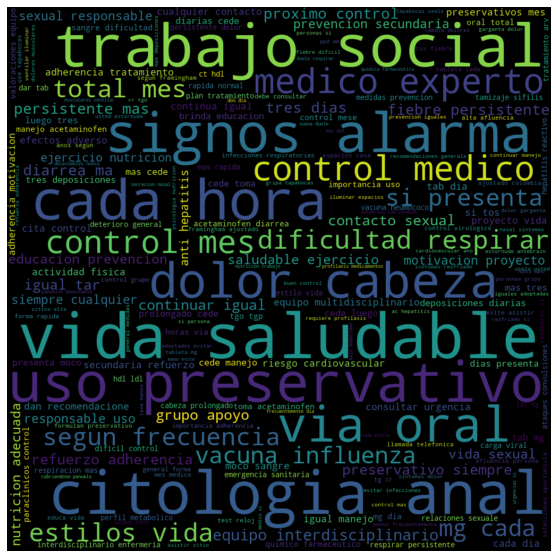

In [64]:
wordcloud = WordCloud(width=1024, height=1024).generate(plan)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

TODO: Talk about most important words found in the wordcloud

In [65]:
plan_series = pd.Series(plan.split())
plan_series.value_counts().to_frame().head(20)

,0
control,143823
mes,80362
dia,60479
vida,59112
mg,57646
pendiente,56064
cada,50595
si,50405
mas,50091
tar,49935


There doesn't seem to be much that can be concluded on in this list. Maybe of note is the TAR, which could indicate "Test de Antigeno Rapido", used for detecting COVID. Let's try and see if we can get anything better by splitting by disease.

In [66]:
def find_top_k_words(string_value:str, k:int=5) -> list:
  string_value = str(string_value).lower()
  # Some text cleaning
  string_value = remove_stop_words(string_value)
  string_value = remove_characters(string_value, ['-', ','])
  # Split into lists for the counter
  split_it = string_value.split()
  counter = Counter(split_it)
  most_common = counter.most_common(k)
  return most_common

In [67]:
notas.groupby('Código')['Plan'] \
    .apply(','.join) \
    .apply(lambda x: find_top_k_words(x, 3)) \
    .to_frame() \
    .explode('Plan')

,Plan
Código,
A510,"(control, 953)"
A510,"(vida, 497)"
A510,"(mas, 442)"
A511,"(dolor, 103)"
A511,"(tar, 103)"
A511,"(si, 101)"
A514,"(control, 2649)"
A514,"(vida, 1594)"
A514,"(si, 1488)"


Of note is the mention of vaccine for A539, and pain and TAR for A511. There seems to be a higher level of control-related words for Syphilis than for Diabetes.

For Diabetes, there seems to be a lot of emphasis on mes, cada, and mg, which would indicate prescription(s) of something.

A deeper dive into n-grams and/or relationships between words, similar to what [GloVe](https://nlp.stanford.edu/projects/glove/) does would be beneficial in the near future.

TODO (Cristian): Comparar Sociodemografico con enfermedades (Nombre) de Notas

In [68]:
notas_sociodemografico = notas.merge(sociodemografico, on='IDRecord')

In [69]:
notas_sociodemografico.head()

,IDRecord,Código,Nombre,Tipo,Plan,Edad,Genero,GrupoEtnico,AreaResidencial,EstadoCivil,TSangre
0,44600.0,A539,"SIFILIS, NO ESPECIFICADA",Confirmado Repetido,- ORDENO TAR ABC +3TC +ATV/r - PROFILAXIS NO ...,53,Hombre,Mestizo,Zona Urbana,Soltero,No reportado
1,44600.0,A539,"SIFILIS, NO ESPECIFICADA",Confirmado Repetido,PACIENTE QUE SE ENCUENTRA EN TRATAMIENTO ANTIR...,53,Hombre,Mestizo,Zona Urbana,Soltero,No reportado
2,44600.0,A539,"SIFILIS, NO ESPECIFICADA",Confirmado Repetido,CONSERVAR ADHERENCIA AL TRATAMIENTO ACUDIR A...,53,Hombre,Mestizo,Zona Urbana,Soltero,No reportado
3,44600.0,A539,"SIFILIS, NO ESPECIFICADA",Confirmado Repetido,1. CONTINUA MISMO TAR TDF+FTC+ATV/r BICONJUGAD...,53,Hombre,Mestizo,Zona Urbana,Soltero,No reportado
4,44600.0,A539,"SIFILIS, NO ESPECIFICADA",Confirmado Repetido,PROXIMA CONSULTA CON ENFERMERIA EN 6 MESES; S...,53,Hombre,Mestizo,Zona Urbana,Soltero,No reportado


In [70]:
bins = [0,20,40,60,80,100]
notas_sociodemografico['Edad'] = pd.cut(notas_sociodemografico['Edad'], bins)
notas_sociodemografico

,IDRecord,Código,Nombre,Tipo,Plan,Edad,Genero,GrupoEtnico,AreaResidencial,EstadoCivil,TSangre
0,44600.0,A539,"SIFILIS, NO ESPECIFICADA",Confirmado Repetido,- ORDENO TAR ABC +3TC +ATV/r - PROFILAXIS NO ...,"(40, 60]",Hombre,Mestizo,Zona Urbana,Soltero,No reportado
1,44600.0,A539,"SIFILIS, NO ESPECIFICADA",Confirmado Repetido,PACIENTE QUE SE ENCUENTRA EN TRATAMIENTO ANTIR...,"(40, 60]",Hombre,Mestizo,Zona Urbana,Soltero,No reportado
2,44600.0,A539,"SIFILIS, NO ESPECIFICADA",Confirmado Repetido,CONSERVAR ADHERENCIA AL TRATAMIENTO ACUDIR A...,"(40, 60]",Hombre,Mestizo,Zona Urbana,Soltero,No reportado
3,44600.0,A539,"SIFILIS, NO ESPECIFICADA",Confirmado Repetido,1. CONTINUA MISMO TAR TDF+FTC+ATV/r BICONJUGAD...,"(40, 60]",Hombre,Mestizo,Zona Urbana,Soltero,No reportado
4,44600.0,A539,"SIFILIS, NO ESPECIFICADA",Confirmado Repetido,PROXIMA CONSULTA CON ENFERMERIA EN 6 MESES; S...,"(40, 60]",Hombre,Mestizo,Zona Urbana,Soltero,No reportado
...,...,...,...,...,...,...,...,...,...,...,...
140167,85348.0,A539,"SIFILIS, NO ESPECIFICADA",Confirmado Repetido,*PLAN: - TARV: NAIVE - OTRA MEDICACION: NO ...,"(20, 40]",Hombre,Mestizo,Zona Urbana,Soltero,No reportado
140168,118895.0,E119,DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...,Confirmado Repetido,"1. PIPERACILINA TAZOBACTAM 4,5 GR IV CADA 8 HO...","(60, 80]",Hombre,Mestizo,Zona Urbana,Casado,O+
140169,106323.0,A539,"SIFILIS, NO ESPECIFICADA",Confirmado Repetido,CONTINUAR TAR CON:tdf ftc atv/r TOMAR EL TAR...,"(20, 40]",Hombre,Mestizo,Zona Urbana,Desconocido,O+
140170,84159.0,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,Plan de manejo: pendiente Control de parac...,"(20, 40]",Mujer,Blanco,Zona Urbana,Soltero,No reportado


In [71]:
notas_edades = notas_sociodemografico.groupby(['Nombre','Edad'])[['Nombre','Edad']].size().to_frame()
notas_edades.head()

0
Nombre                                             Edad           
DIABETES MELLITUS NOINSULINODEPENDIENTE SIN MEN... (0, 20]       0
                                                   (20, 40]    660
                                                   (40, 60]   5479
                                                   (60, 80]   7142
                                                   (80, 100]  4043

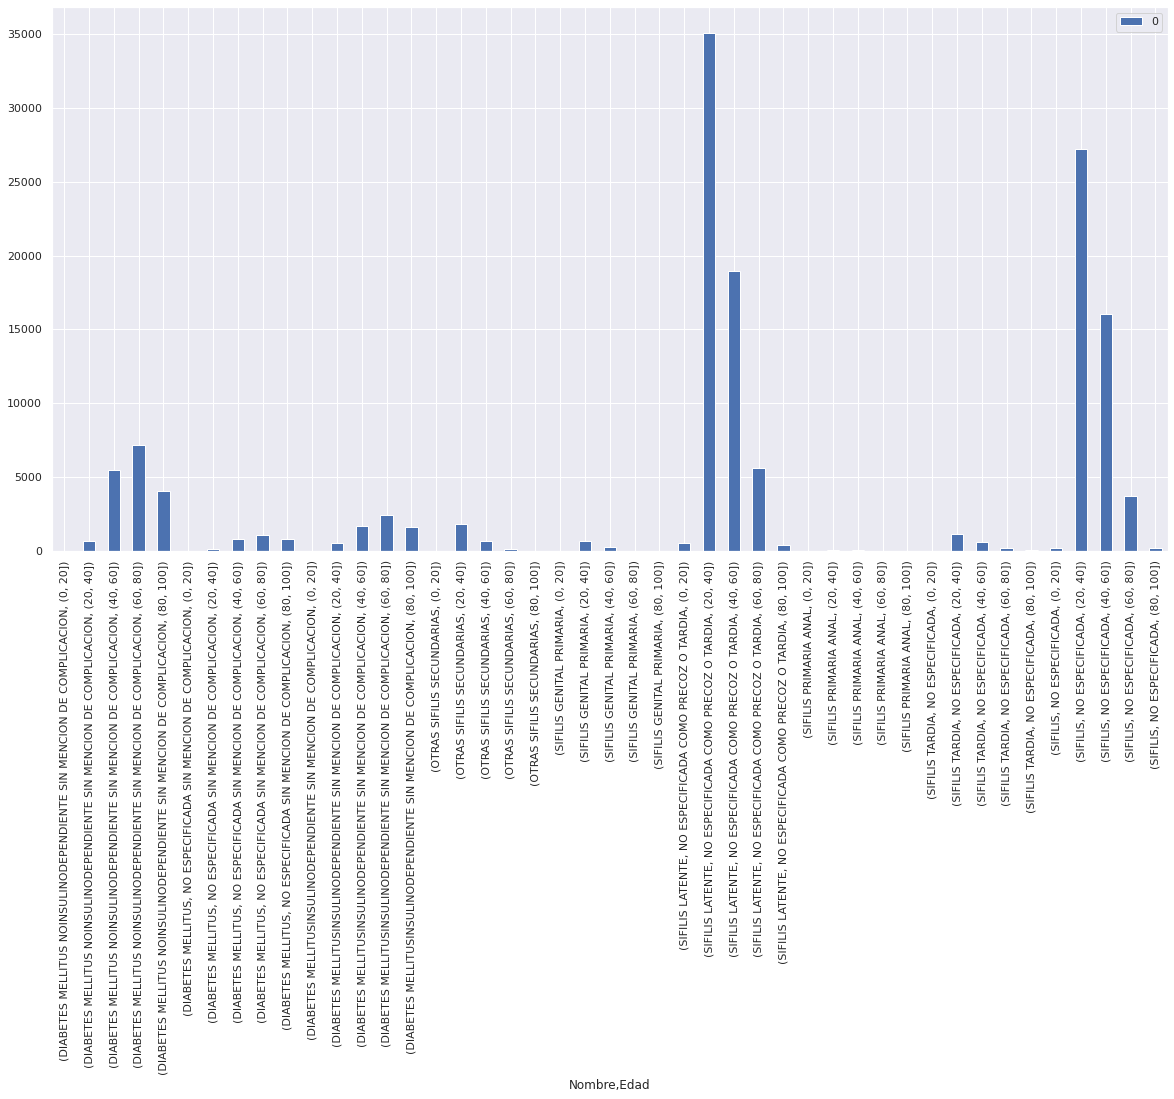

In [72]:
my_plot = notas_edades.plot(kind="bar")
plt.show() 

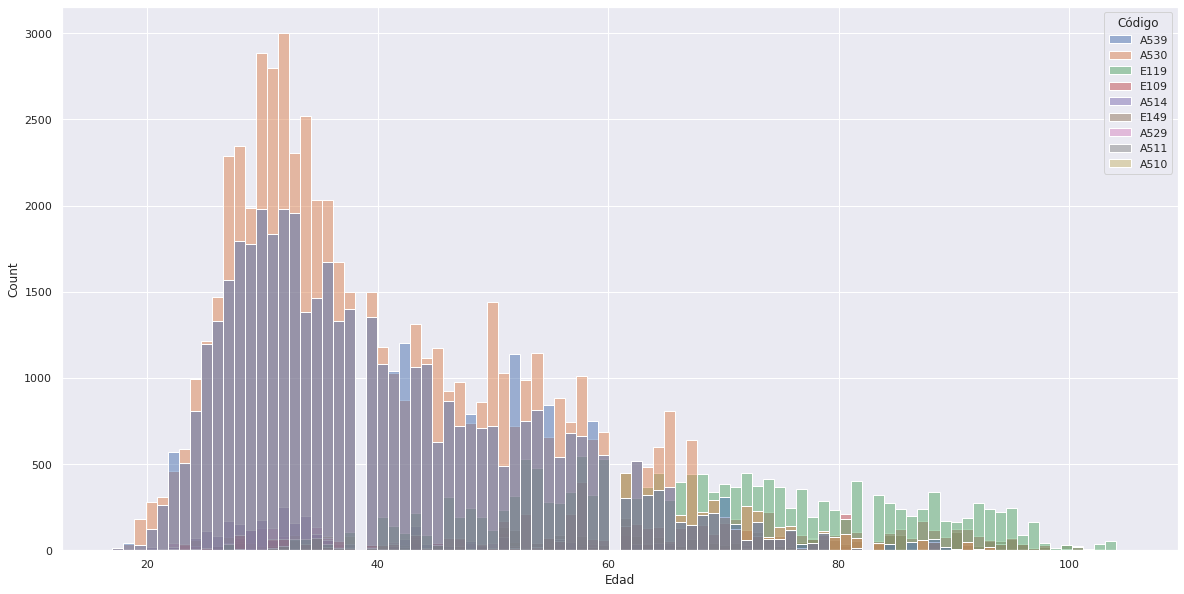

In [73]:
sns.histplot(data=notas.merge(sociodemografico, on='IDRecord'), x="Edad", hue='Código')

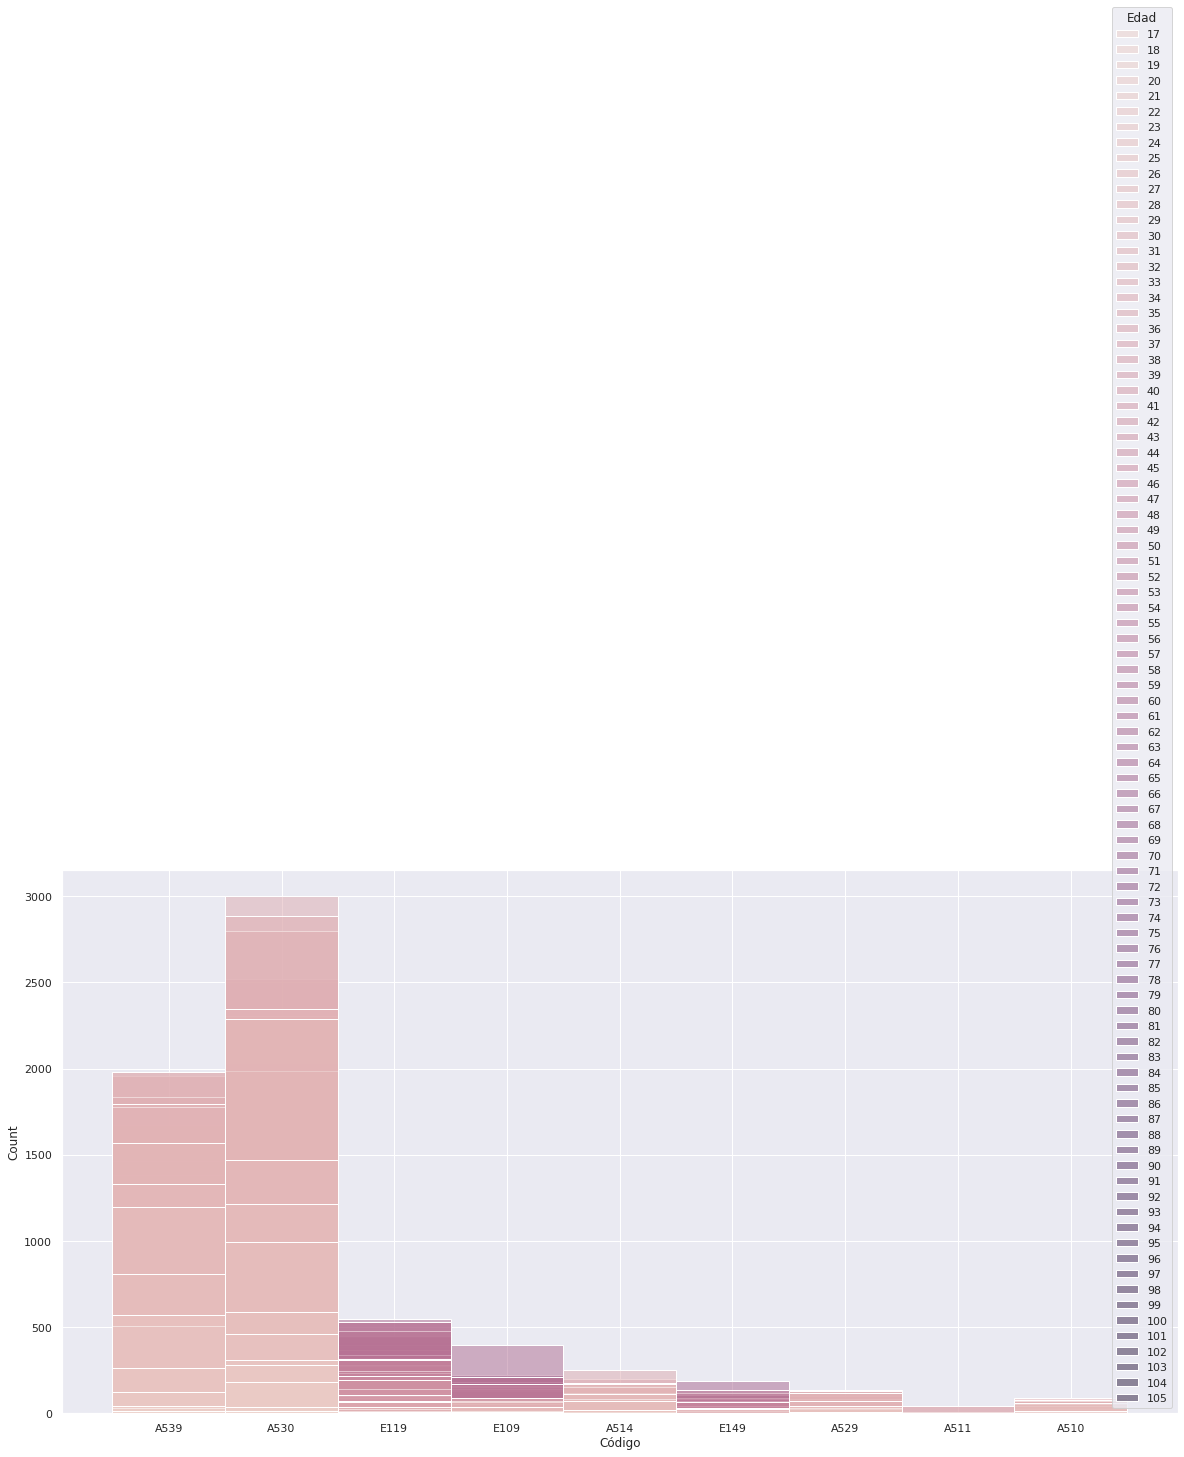

In [74]:
sns.histplot(data=notas.merge(sociodemografico, on='IDRecord'), x="Código", hue='Edad')

In [ ]:
g = sns.catplot(
    x="Edad",
    y="EstadoCivil",
    hue="Código",
    col="GrupoEtnico",
    col_wrap=3,
    data=notas.merge(sociodemografico, on='IDRecord')
    )

TODO (Charic): Comparar Laboratorios con enfermedades (Nombre) de Notas 

# Conclusions

- The datset is heavily unbalanced, featurewise and target class-wise.
- There are a total of 9 diseases that can be predicted on, that can be globbaly classified into Diabetes and Syphilis.
- There are some features which might need to be dropped, as there are too many missing values and they can't be recovered/input.
- A deeper analysis of the target feature and it's relationship with the EHR is needed to further understand the problem.